<a href="https://www.advfn.com/nasdaq/nasdaq.asp?companies=A">Nasdaq Stocks</a>

In [1]:
from datetime import datetime, timedelta
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

In [2]:
with open('../data/all_symbols.pkl', 'rb') as f:
    all_symbols = pickle.load(f)
    
len(all_symbols)

11032

In [3]:
def prepare_batches(all_symbols, batch_size=100):
    n = len(all_symbols)
    batches = []
    batch_start = 0
    batch_end = min(batch_start + batch_size, n)
    while batch_start < n:
        batches.append(all_symbols[batch_start:batch_end])
        batch_start = batch_end
        batch_end = min(batch_start + batch_size, n)
    return batches

In [4]:
batches = prepare_batches(all_symbols)

In [5]:
states = pd.read_csv('../data/hmm_exp_returns.csv')
states = states[['Date', 'state']]
states.index = pd.to_datetime(states.Date)
states.drop(columns='Date', inplace=True)
states.head()

,state
Date,
1950-01-03,3
1950-01-04,3
1950-01-05,3
1950-01-06,3
1950-01-09,3


In [6]:
STATES = sorted(states.state.unique())
STATES

[0, 1, 2, 3, 4, 5]

In [7]:
CURRENT_STATE = states.state.to_numpy()[-1]
CURRENT_STATE

0

In [8]:
RUN = {
    0: 'all',
    1: 0,  # specific batch
    2: 'random_batch'
}[0]
MIN_OVERALL_SHARPE = 0.45
MIN_STOCK_PRICE = 1.00

In [9]:
if RUN == 'random_batch':
    n_batches = len(batches)
    idx = np.random.randint(0, n_batches)
    run_batches = [batches[idx]]
elif isinstance(RUN, int):
    run_batches = [batches[RUN]]
else:
    run_batches = batches
    
print('n batches:', len(run_batches))

n batches: 111


In [10]:
TODAY = (datetime.now() + timedelta(1)).date()
YEARS_OF_DATA = 10
MIN_YEARS = 5
START = TODAY - timedelta(YEARS_OF_DATA * 365)
min_start = TODAY - timedelta(MIN_YEARS * 365)
if min_start.weekday() == 0:
    min_start -= timedelta(2)
elif min_start.weekday() == 6:
    min_start -= timedelta(1)
START, TODAY, min_start, min_start.weekday()

(datetime.date(2012, 9, 12),
 datetime.date(2022, 9, 10),
 datetime.date(2017, 9, 9),
 5)

In [11]:
START, TODAY

(datetime.date(2012, 9, 12), datetime.date(2022, 9, 10))

In [12]:
def download_data(symbols):
    std_out = sys.stdout
    null = open(os.devnull, 'w')
    sys.stdout = null
    try:
        data = (
            yf
            .download(symbols, start=START, end=TODAY)
            .rename(columns={'Adj Close': 'AdjClose'}))['AdjClose']
        data.index = pd.to_datetime(data.index)
        data = data.sort_index()
        data = data.loc[:, data.isnull().sum() != len(data)]
        missing_last = [
            col for col in list(data) if data[col].isnull()[-1]]
        data.drop(columns=missing_last, inplace=True)
        sys.stdout = std_out
        return data
    except BaseException as e:
        print(f'Failed to download data:\n{e}')

In [13]:
def adjust_min_date(min_date, dates):
    while pd.to_datetime(min_date) not in dates:
        min_date -= timedelta(1)
    return min_date

In [14]:
def filter_by_min_date(data, min_date):
    for col in data.columns:
        #if np.isnan(data.at[pd.to_datetime(min_date), col]):
        #    data.drop(columns=[col], inplace=True)
        if (
                data[col][data[col].notnull()].index[0] 
                > pd.to_datetime(min_date)):
            data.drop(columns=[col], inplace=True)
    return data

In [15]:
def filter_by_min_price(data):
    for col in data.columns:
        if (
                data[col][data[col].notnull()].to_numpy()[-1]
                < MIN_STOCK_PRICE):
            data.drop(columns=[col], inplace=True)
    return data

In [16]:
def get_daily_returns(x):
    idx = x.index
    n = len(x)
    x = np.array(x)
    returns = x[1:n] / x[0:(n-1)] - 1
    returns = pd.Series(returns, index=idx[1:])
    return returns

In [17]:
def get_sharpe(returns, window=None):
    n = len(returns)
    if window is None:
        window = n
    if len(returns) > window:
        returns = returns[(n - window):n]
    returns = returns[~np.isnan(returns)]
    sharpe = (np.sqrt(252) * returns.mean()) / returns.std()
    return sharpe

In [18]:
def get_sharpes_by_state(data):
    output = []
    stocks = [col for col in list(data) if col != 'state']
    for stock in stocks:
        stock_data = []
        returns = get_daily_returns(data[stock])
        sharpe = get_sharpe(returns)
        stock_data.append(sharpe)
        for state in STATES:
            sharpe_state = get_sharpe(returns[data.state == state])
            stock_data.append(sharpe_state)
        output.append(stock_data)
    df_out = pd.DataFrame(
        output,
        columns=['sharpe'] + [f'sharpe_{state}' for state in STATES],
        index=stocks)
    return df_out

In [19]:
def best_n_by_state(df, n, state):
    candidates = df[df.sharpe >= MIN_OVERALL_SHARPE]
    return (
        candidates
        .sort_values(f'sharpe_{state}', ascending=False)
        .index[:n])

In [20]:
def process_batch(batch, min_start):
    data = download_data(batch)
    min_start = adjust_min_date(min_start, data.index)
    data = filter_by_min_date(data, min_start)
    data = filter_by_min_price(data)
    data = pd.concat([data, states], axis=1).loc[data.index, :]
    state_sharpes = get_sharpes_by_state(data)
    return state_sharpes

In [21]:
dfs = []
print('Beginning batch:')
for batch in batches:
    print(batch[0], end=' ')
    df = process_batch(batch, min_start)
    dfs.append(df)

Beginning batch:
A ACER ADXS AHAC ALJJ AMOT APEN ARII ASVI 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_62001/2417818282.py:8: RuntimeWarning: invalid value encountered in double_scalars
  sharpe = (np.sqrt(252) * returns.mean()) / returns.std()


AVCO BAH BDJ BIE 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_62001/2417818282.py:8: RuntimeWarning: invalid value encountered in double_scalars
  sharpe = (np.sqrt(252) * returns.mean()) / returns.std()


BLTI BR BTI CACQ CBNK CDTX CGFW CIT CLWT CNVX CPLG 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_62001/2417818282.py:8: RuntimeWarning: invalid value encountered in double_scalars
  sharpe = (np.sqrt(252) * returns.mean()) / returns.std()


CSBR CUBI 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_62001/2417818282.py:8: RuntimeWarning: invalid value encountered in double_scalars
  sharpe = (np.sqrt(252) * returns.mean()) / returns.std()


CYPB DEA DLGC 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_62001/2417818282.py:8: RuntimeWarning: invalid value encountered in double_scalars
  sharpe = (np.sqrt(252) * returns.mean()) / returns.std()


DRIO DXCM EE EMBC EPM ETR EZGO 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_62001/2417818282.py:8: RuntimeWarning: invalid value encountered in double_scalars
  sharpe = (np.sqrt(252) * returns.mean()) / returns.std()


FE 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_62001/2417818282.py:8: RuntimeWarning: invalid value encountered in double_scalars
  sharpe = (np.sqrt(252) * returns.mean()) / returns.std()


FIV FNVT FSLA FXJP GENI GLBC GOAM GSM HBCP HGLB HOG HTRN 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_62001/2417818282.py:8: RuntimeWarning: invalid value encountered in double_scalars
  sharpe = (np.sqrt(252) * returns.mean()) / returns.std()


ICAB IGU INHO IPVI IVR JMSB KERX KRMD LCA LIN LPI 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_62001/1541653759.py:5: RuntimeWarning: divide by zero encountered in divide
  returns = x[1:n] / x[0:(n-1)] - 1


LYV MCD MERX MIR MNTK 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_62001/2417818282.py:8: RuntimeWarning: invalid value encountered in double_scalars
  sharpe = (np.sqrt(252) * returns.mean()) / returns.std()


MS MUE NAV NETI NM NRDS NURO NYXH 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_62001/2417818282.py:8: RuntimeWarning: invalid value encountered in double_scalars
  sharpe = (np.sqrt(252) * returns.mean()) / returns.std()


OLLI ORCL PACX 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_62001/2417818282.py:8: RuntimeWarning: invalid value encountered in double_scalars
  sharpe = (np.sqrt(252) * returns.mean()) / returns.std()


PCX PGHD PLL POWW 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_62001/2417818282.py:8: RuntimeWarning: invalid value encountered in double_scalars
  sharpe = (np.sqrt(252) * returns.mean()) / returns.std()
/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_62001/1541653759.py:5: RuntimeWarning: divide by zero encountered in divide
  returns = x[1:n] / x[0:(n-1)] - 1
/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_62001/1541653759.py:5: RuntimeWarning: invalid value encountered in divide
  returns = x[1:n] / x[0:(n-1)] - 1


PSAG PXMD 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_62001/2417818282.py:8: RuntimeWarning: invalid value encountered in double_scalars
  sharpe = (np.sqrt(252) * returns.mean()) / returns.std()


RADI RENT RLTY RRI SAGA SCLN SFLY SILV SMMC SOLO SRCH STJ 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_62001/2417818282.py:8: RuntimeWarning: invalid value encountered in double_scalars
  sharpe = (np.sqrt(252) * returns.mean()) / returns.std()


SWBD TBBK TFC TLEO TPPP TSHA TYDE UNFI VAC 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_62001/2417818282.py:8: RuntimeWarning: invalid value encountered in double_scalars
  sharpe = (np.sqrt(252) * returns.mean()) / returns.std()


VINT VQS VYNE WGO WRE XENE 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_62001/1541653759.py:5: RuntimeWarning: divide by zero encountered in divide
  returns = x[1:n] / x[0:(n-1)] - 1


YDKN ZOM 

In [22]:
df = pd.concat(dfs, axis=0)
df.head()

,sharpe,sharpe_0,sharpe_1,sharpe_2,sharpe_3,sharpe_4,sharpe_5
A,0.807022,-1.775251,2.070522,1.595616,1.593359,2.797903,2.375961
AA,0.430693,-1.077974,2.472095,-4.181647,-0.037692,0.826476,1.312187
AAIC,0.008965,-0.821461,0.274974,-0.925817,1.730397,1.134077,0.429798
AAL,0.295176,-1.218866,1.436956,1.260045,1.211539,0.992871,1.301623
AAME,0.335569,-0.233721,1.299779,1.888614,0.770873,0.058304,-0.097681


In [23]:
df.tail()

,sharpe,sharpe_0,sharpe_1,sharpe_2,sharpe_3,sharpe_4,sharpe_5
ZUMZ,0.246881,-0.943910,0.707886,6.398344,0.186828,0.407679,0.988497
ZWS,0.335826,-1.406073,1.057415,4.551935,0.085322,2.086841,1.874022
ZYME,0.072714,-1.172077,0.202038,-32.382271,-0.219616,1.499442,1.428334
ZYNE,0.144816,-1.827839,0.651731,0.779246,0.893741,0.494997,1.068930
ZYXI,0.834054,0.847278,0.220851,-0.913326,1.388023,0.456574,1.169849


In [24]:
df.to_csv('../data/sharpes_by_state.csv', index=True)

In [25]:
CURRENT_STATE = 0

In [36]:
exclude = {
    0: [
        'AHPI', 'AIKI', 'BRTX', 'BTTR', 'CODX', 'ELA', 'ESOA', 'FFDF',
        'GCTK', 'GMCI', 'HMY', 'IPA', 'IVDA', 'IVT', 'LGMK', 'MTA',
        'NCPL', 'NNVC', 'OLB', 'PALT', 'PMTS', 'PRTG', 'SOBR', 'VIVK',
        'VXRT','ZEST']}

In [37]:
# Weighted Best
# 3: 0.2, 0.6, 0.2
# 2: 0.6, 0.4
df['weighted'] = 0.8*df.sharpe_0 + 0.2*df.sharpe_1# + 0.25 * df.sharpe_2
df = df.sort_values('weighted', ascending=False)
df.head()

,sharpe,sharpe_0,sharpe_1,sharpe_2,sharpe_3,sharpe_4,sharpe_5,weighted
AMRK,0.660453,1.104785,2.403900,7.361426,0.930935,-0.532273,-0.750498,1.364608
OMQS,0.556283,1.043836,1.690207,-3.653711,0.613358,0.762077,0.499637,1.173110
ESOA,0.674245,1.167424,1.182503,-3.011614,0.348206,-0.037694,0.306935,1.170440
FFDF,1.241249,1.136471,1.139518,-3.351139,1.191846,1.295114,1.558879,1.137080
PMTS,0.299969,1.235991,0.644272,-9.185582,1.596271,1.189444,-1.219445,1.117647


In [45]:
df.mean(), df.median()

(sharpe      0.395753
 sharpe_0   -0.923886
 sharpe_1    1.150107
 sharpe_2    0.329373
 sharpe_3    1.276535
 sharpe_4    1.043998
 sharpe_5    1.094899
 weighted   -0.509088
 dtype: float64,
 sharpe      0.391509
 sharpe_0   -0.954362
 sharpe_1    1.156308
 sharpe_2    1.345059
 sharpe_3    1.253499
 sharpe_4    1.027153
 sharpe_5    1.042699
 weighted   -0.535413
 dtype: float64)

In [38]:
best_weighted = [
    s for s in df.index if s not in exclude[CURRENT_STATE]
][:20]
sorted(best_weighted)

['AMRK',
 'APT',
 'CELH',
 'EP',
 'GBOX',
 'GCBC',
 'GME',
 'GMGI',
 'IEI',
 'MCVT',
 'MICS',
 'OMQS',
 'ORLA',
 'POWW',
 'PRPH',
 'SBOW',
 'VIRT',
 'VIVO',
 'WAVD',
 'WKHS']

In [39]:
df.loc[best_weighted]

,sharpe,sharpe_0,sharpe_1,sharpe_2,sharpe_3,sharpe_4,sharpe_5,weighted
AMRK,0.660453,1.104785,2.403900,7.361426,0.930935,-0.532273,-0.750498,1.364608
OMQS,0.556283,1.043836,1.690207,-3.653711,0.613358,0.762077,0.499637,1.173110
GBOX,1.208390,0.979131,1.640384,-1.199274,1.168258,1.181494,1.204848,1.111382
MICS,0.721671,1.005186,1.030673,-3.893499,0.752038,0.688795,0.270495,1.010283
PRPH,0.735636,1.020920,0.720890,-5.128406,0.860982,0.503677,0.566656,0.960914
EP,0.963190,0.932675,0.779305,-5.612486,1.379670,0.420602,1.122404,0.902001
GME,0.754904,1.120208,-0.061039,-2.703975,2.564168,0.063235,0.367320,0.883959
WAVD,0.721893,0.741546,1.211426,-8.117830,0.580821,1.079174,0.490619,0.835522
CELH,1.057427,0.647393,1.460480,-11.823012,1.818300,0.634684,1.018491,0.810011
SBOW,0.385694,0.109412,3.601163,-5.117607,0.114709,0.212580,-0.558059,0.807762


In [40]:
data = (
    yf
    .download(best_weighted, start=START, end=TODAY)
    .rename(columns={'Adj Close': 'AdjClose'}))['AdjClose']

[*********************100%***********************]  20 of 20 completed


In [41]:
data.index = pd.to_datetime(data.index)
data = data.sort_index()
data.tail()

,AMRK,APT,CELH,EP,GBOX,GCBC,GME,GMGI,IEI,MCVT,MICS,OMQS,ORLA,POWW,PRPH,SBOW,VIRT,VIVO,WAVD,WKHS
Date,,,,,,,,,,,,,,,,,,,,
2022-09-02,28.910000,4.16,96.360001,14.88,1.07,53.810001,27.360001,3.61,117.860001,3.370,7.87,6.207,3.39,3.63,11.30,38.930000,22.580000,32.599998,1.16,2.99
2022-09-06,27.950001,4.10,93.820000,14.44,1.16,53.750000,25.139999,3.94,117.150002,3.500,7.54,6.100,3.17,3.53,11.05,38.950001,21.620001,31.990000,1.06,2.94
2022-09-07,28.820000,4.10,98.930000,14.72,1.12,54.950001,24.040001,3.94,117.639999,3.190,7.95,6.150,3.30,3.54,11.25,36.509998,22.030001,31.950001,1.20,3.07
2022-09-08,29.740000,4.16,104.980003,14.63,1.17,55.849998,25.830000,3.90,117.330002,3.167,7.36,6.185,3.26,3.63,10.79,36.680000,22.330000,31.980000,1.24,3.06
2022-09-09,29.049999,4.20,105.930000,14.68,1.24,54.900002,28.920000,3.88,117.250000,2.980,7.90,6.340,3.24,3.83,11.12,37.560001,22.570000,32.009998,1.28,3.13


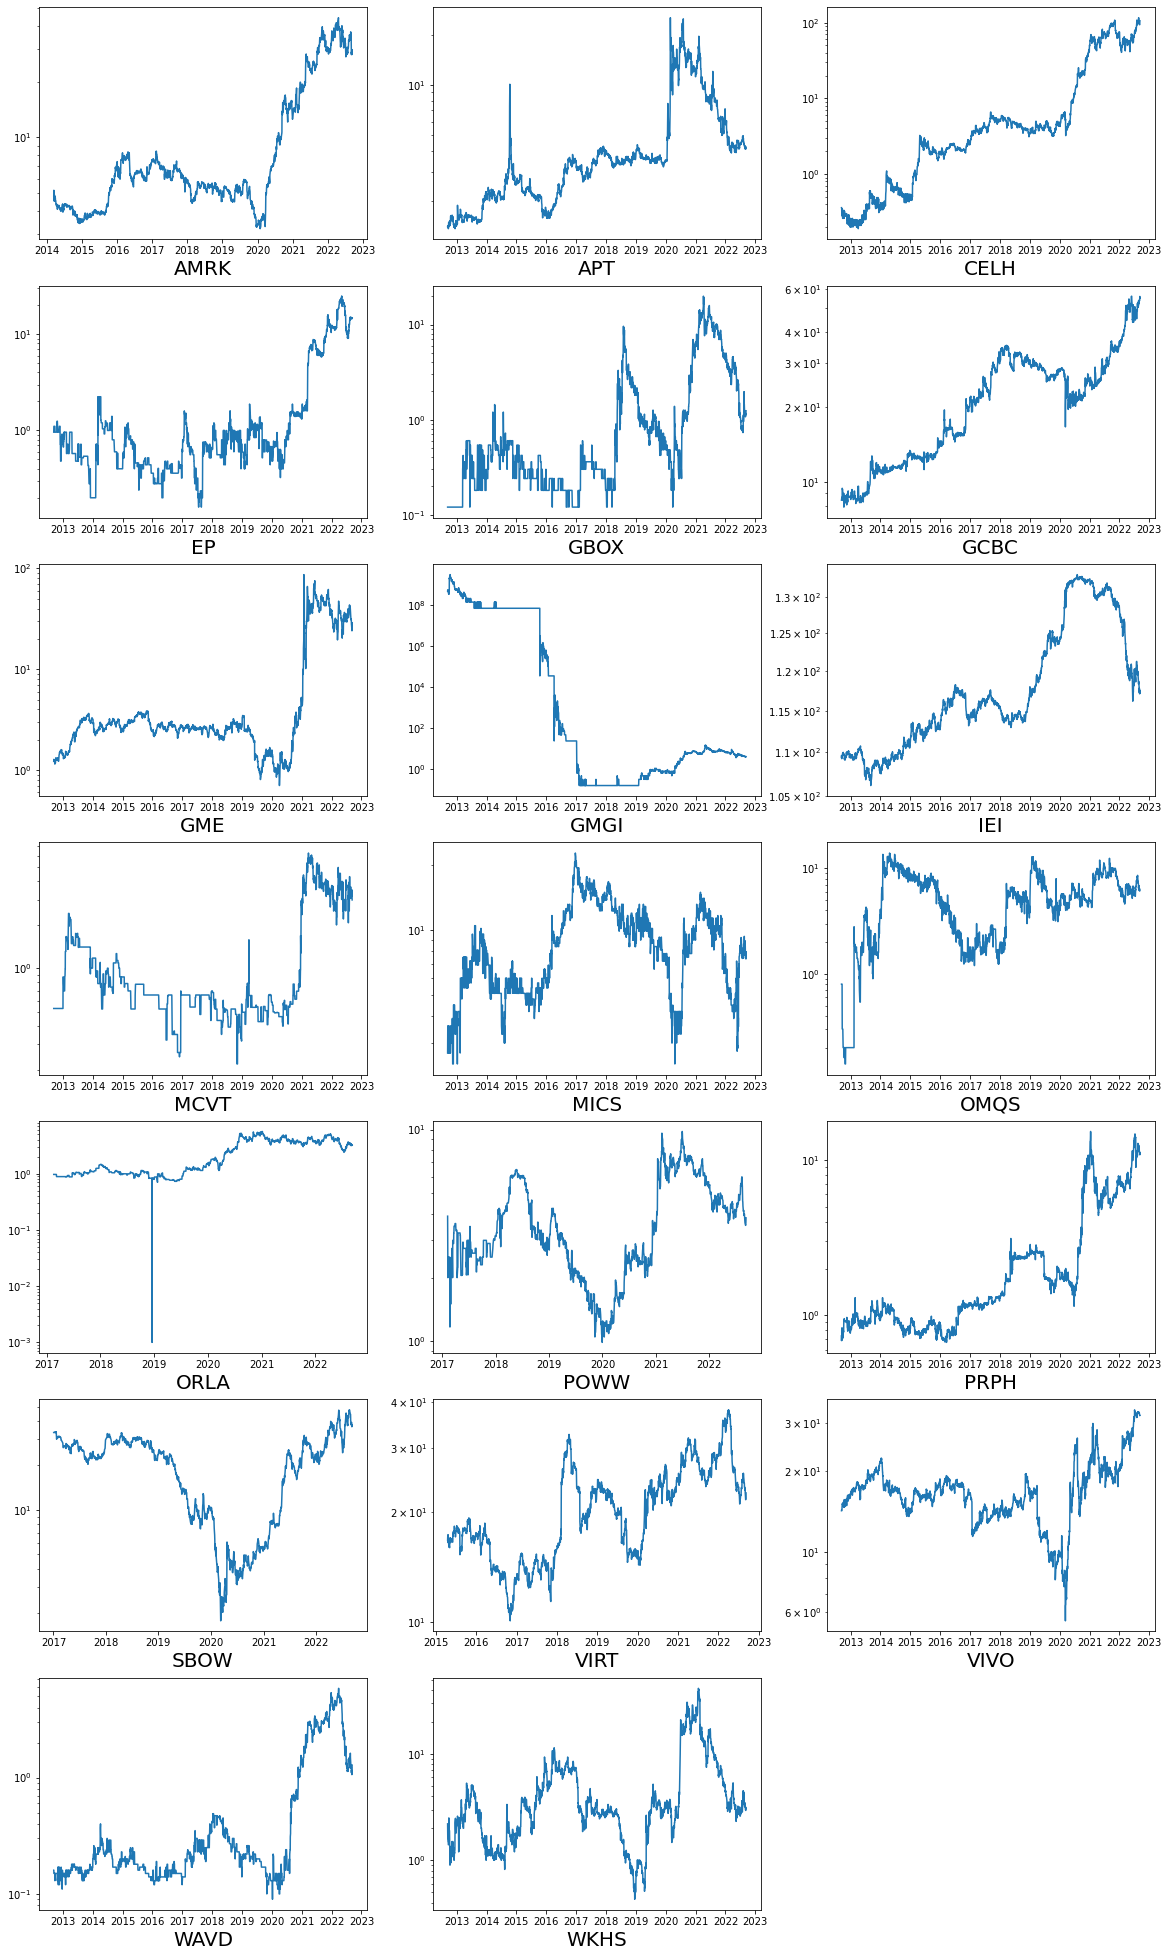

In [42]:
plt.rc('axes', labelsize=20)
plt.figure(figsize=[20, 35])
for i, sym in enumerate(list(data)):
    plt.subplot(7, 3, i + 1)
    plt.plot(data[sym])
    plt.xlabel(sym)
    plt.yscale('log');

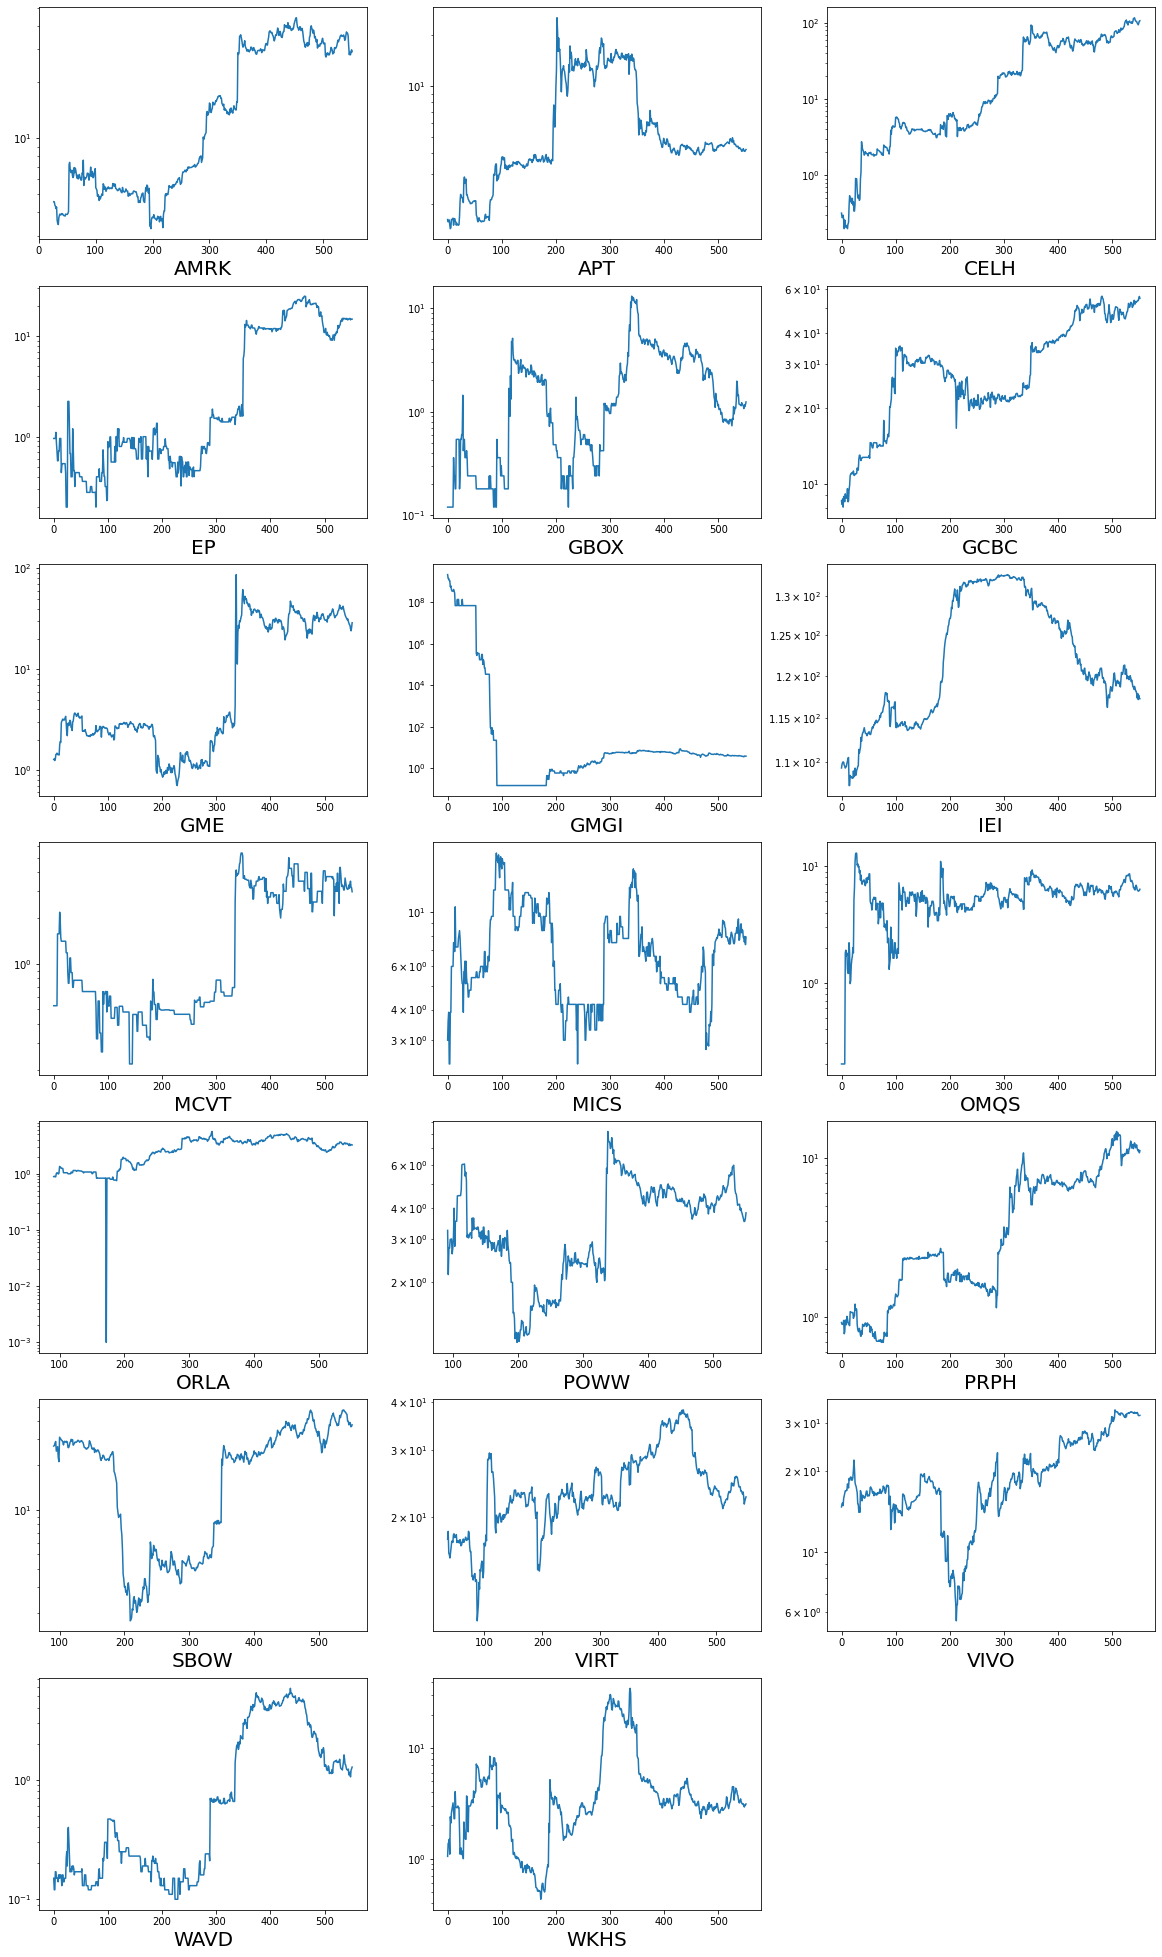

In [43]:
plt.figure(figsize=[20, 35])
for i, sym in enumerate(list(data)):
    plt.subplot(7, 3, i + 1)
    plt.plot(data.loc[states.state == CURRENT_STATE, sym].to_numpy())
    plt.yscale('log')
    plt.xlabel(sym);

In [34]:
# Hedged best

hedged = (
    #df[['sharpe_3', 'sharpe_4', 'sharpe_5']]
    df[['sharpe_0', 'sharpe_1', 'sharpe_2']]
    .min(axis=1)
    .sort_values(ascending=False))
df.loc[hedged.index, :]

,sharpe,sharpe_0,sharpe_1,sharpe_2,sharpe_3,sharpe_4,sharpe_5,weighted
AMRK,0.660453,1.104785,2.403900,7.361426,0.930935,-0.532273,-0.750498,1.364608
NCPL,0.322835,0.838093,0.804199,5.612486,1.348285,1.634177,1.485214,0.831315
GCTK,0.586262,0.779922,0.744793,3.415647,0.557705,0.472638,0.271452,0.772896
VIVK,0.919106,0.724787,1.221273,3.073347,1.038059,0.978445,0.805885,0.824085
HMY,0.141209,0.677420,1.163097,4.571931,-1.134256,-0.339494,-0.242591,0.774556
...,...,...,...,...,...,...,...,...
SRTS,0.530754,0.621320,0.225459,-128.638271,1.697693,0.913164,0.140897,0.542148
PIXY,-0.059284,-0.195246,0.394938,-132.093869,0.970646,-2.133906,0.355472,-0.077209
LVO,-0.147390,0.145284,-0.613665,-194.689327,1.605487,-1.723272,-0.365551,-0.006506
EVTV,0.251164,0.542676,0.185047,-1156.173203,-1.168082,0.110804,0.298373,0.471150


In [25]:
#for stock in df_out.index:
#    if stock in big_df.index:
#        big_df.loc[stock, :] = big_df.loc[stock, :]
#    else:
#        big_df = pd.concat(
#            [big_df, pd.DataFrame(df_out.loc[stock, :]).T], axis=0)
#print(big_df.shape)
#big_df.head()

In [61]:
best_0 = best_n_by_state(df, 12, 0)
best_1 = best_n_by_state(df, 20, 1)
best_2 = best_n_by_state(df, 10, 2)
best_3 = best_n_by_state(df, 10, 3)

In [62]:
best_1 = [s for s in best_1 if s not in exclude]
df.loc[best_1, ['sharpe', 'sharpe_0', 'sharpe_1']]

,sharpe,sharpe_0,sharpe_1
PSA,0.650748,-1.573871,2.381544
EXR,1.002172,-1.281449,2.296653
LSI,0.792455,-1.354776,2.245297
CUBE,0.786320,-1.394105,2.159637
TWNK,0.624425,-2.070600,2.104215
WCN,1.166216,-2.464539,2.097525
EVA,0.867700,-1.673559,1.989497
REXR,0.878333,-2.413490,1.971078
NSA,0.896763,-0.885810,1.874567
TSLA,1.159955,-2.607051,1.864281
